# Adversarial attacks playground

NNDL Project Fall 2022
2022-11-30

## 0. Notebook Setup

Imports

In [2]:
import os

import torch
import torchvision
from torchvision import models as models

from src.explainability.GradCam import GradCam
from src.utils.ImageDisplayerGradCam import ImageDisplayerGradCam
from src.data.ImageNet300 import ImageNet300Dataset
from src.utils.getimagenetclasses import get_classes

In [3]:
torch.__version__

'1.13.0'

global params

''

In [4]:
DATA_FOLDER = os.path.join(os.path.abspath(""),"src/data/")
USE_CUDA = False

print(DATA_FOLDER)

/Users/lennartschulze/Downloads/NNDL/project/dlnn-project/src/data/


## 1. Params

### MNIST & GoogLeNet

#### MNIST dataset

In [5]:
dataset = torchvision.datasets.MNIST(root=DATA_FOLDER, 
    train=False,download=True, transform=torchvision.transforms.ToTensor())

#### GoogLeNet Model

In [6]:
torchvision.models.list_models()

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

In [6]:
#model = models.GoogLeNet(models.GoogLeNet_Weights.IMAGENET1K_V1)
#model = models.GoogLeNet(weights="IMAGENET1K_V1")
#model = models.googlenet.GoogLeNet(weights=models.googlenet.GoogLeNet_Weights.DEFAULT)

### A)
model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT, transform_input=False)
### B)
#model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

In [7]:
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (USE_CUDA and torch.cuda.is_available()) else "cpu")
# Initialize the network
model.to(device)
model.eval()

CUDA Available:  False


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

## 2. Attack

### 2.1 Fast gradient sign method

In [37]:
# if smaller subset desired
indices = torch.randperm(len(dataset))[:100]
data_loader = torch.utils.data.DataLoader(dataset,batch_size=100,#shuffle=True,
    sampler=torch.utils.data.SubsetRandomSampler(indices))

In [9]:
def fgsm_perturbate(image, epsilon, data_grad):
    sign = data_grad.sign() # sign of gradient
    perturbed_image = image + epsilon * sign
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [38]:
# requires batch_size=1
epsilon = 0.00

correct, incorrect = 0,0
# adapt model to have output 10 (image classes)
# need to train again !!!
model.fc = torch.nn.Linear(model.fc.in_features, 10) # !!! CAN WE DO THIS?
    
for img, target in data_loader:
    # adapt input to be nx3xhxw
    if img.size()[1] == 1:
        img = img.expand((img.size()[0], 3, img.size()[2], img.size()[3]))
    
    img, target = img.to(device), target.to(device)
    img.requires_grad = True
    #print(img.size())
    output = model(img) # probabilities
    #print("output:", output.size(), output)
    init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    print("init_pred", init_pred.size())

    # skip images that were wrongly classified in the first place
    if init_pred.item() != target.item():
        print(init_pred.item(), target.item())
        continue
    else:
        print("else")
        print(init_pred.item(), target.item())
        # Calculate the loss
        loss = torch.nn.functional.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # produce FGSM Attack
        grad_wrt_data = img.grad.data
        perturbed_img = fgsm_perturbate(img, epsilon, grad_wrt_data)

        # Re-classify the perturbed image
        print("perturbed input", perturbed_img.shape)
        output = model(perturbed_img)
        print("OUTPUT ", output)
        pred = output.max(1, keepdim=True)[1]
        print("PREDICTION 1", pred)

        if pred.item() == target.item():
            correct += 1
        else:
            incorrect += 1
length = correct+incorrect
print(correct, "correct")
print(incorrect, "incorrect")
length = float(length)
print(length)
accuracy = correct / length
print(f"accuracy: {accuracy}, \t correct: {correct} ({correct/length}) \t incorrect: {incorrect} ({incorrect/length})")

init_pred torch.Size([100, 1])


ValueError: only one element tensors can be converted to Python scalars

### 2.2 UNIVERSAL PERTURBATIONS

In [76]:
# if smaller subset desired
indices = torch.randperm(len(dataset))[:100]
data_loader = torch.utils.data.DataLoader(dataset,batch_size=50,#shuffle=True,
    sampler=torch.utils.data.SubsetRandomSampler(indices))

In [20]:
%load_ext autoreload
%autoreload 2
from src.attacks.attacks import UniversalPerturbation

In [86]:

model.fc = torch.nn.Linear(model.fc.in_features, 10) # !!! CAN WE DO THIS?
    
for inputs, targets in data_loader:
    #print(inputs.size(), targets.size())
    if inputs.size()[-3] == 1:
        inputs = inputs.expand((inputs.size()[0], 3, inputs.size()[2], inputs.size()[3]))
    #print(inputs.size(), targets.size())
inputs, targets = inputs.to(device), targets.to(device)
up = UniversalPerturbation(model, torch.nn.functional.nll_loss).compute_perturbation(inputs, targets)

inputs torch.Size([50, 3, 28, 28])
predictions:  torch.Size([50]) 

targets torch.Size([50]) 

fool_rate 0.88
0
predictions:  torch.Size([50]) 

targets torch.Size([50]) 

fool_rate 0.96


In [88]:
up.size()

torch.Size([1, 3, 28, 28])

## 3. Explanation

In [183]:
from src.explainability.GradCam import GradCam
from src.utils.get_mnist_classes import get_classes
from torchvision import transforms
import matplotlib.pyplot as plt
import PIL.Image
import numpy as np

In [106]:
for name, module in list(model.named_modules())[-10:]:
    #if isinstance(module, torch.nn.Conv2d):
    print(name, module)

model.conv2d

inception5b.branch3.1.conv Conv2d(48, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
inception5b.branch3.1.bn BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
inception5b.branch4 Sequential(
  (0): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=True)
  (1): BasicConv2d(
    (conv): Conv2d(832, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
)
inception5b.branch4.0 MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=True)
inception5b.branch4.1 BasicConv2d(
  (conv): Conv2d(832, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)
inception5b.branch4.1.conv Conv2d(832, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
inception5b.branch4.1.bn BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_s

AttributeError: 'GoogLeNet' object has no attribute 'conv2d'

In [115]:
print(list(model.modules())[-5])

Conv2d(832, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [175]:
indices = torch.randperm(len(dataset))[:100]
data_loader = torch.utils.data.DataLoader(dataset,batch_size=1,#shuffle=True,
    sampler=torch.utils.data.SubsetRandomSampler(indices))

In [137]:
target_layer = list(model.modules())[-5]
cam = GradCam(model, target_layer, 10, multi_label = False)
classes = get_classes()
print(classes)


{0: 'zero', 1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', 6: 'six', 7: 'seven', 8: 'eight', 9: 'nine'}


In [144]:
image_dispalyer = ImageDisplayerGradCam(model, 
    cam, 
    classes,
    reshape = transforms.Resize((256,256)), 
    multi_label = False, 
    image_dir = 'src/data/MNIST/raw/',
    pdf = False)

1
torch.Size([1, 3, 28, 28]) torch.Size([28, 28, 3, 1])
tensor([6])
True class: six 6
Predictions: three 3
Displaying predictions
Focus class: 3
_display_target_class torch.Size([1, 3, 28, 28])
torch.Size([3, 28, 28])


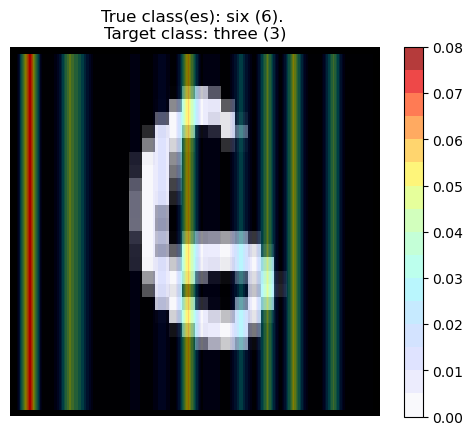

[[0.00391789 0.07578273 0.         0.00608248 0.04770609 0.02755894
  0.         0.         0.         0.00812866 0.         0.0146515
  0.         0.05770095 0.00465251 0.00871043 0.         0.02997743
  0.         0.0461446  0.         0.05133308 0.00545314 0.00081753
  0.04171945 0.         0.         0.0010814 ]
 [0.00391789 0.07578273 0.         0.00608248 0.04770609 0.02755894
  0.         0.         0.         0.00812866 0.         0.0146515
  0.         0.05770095 0.00465251 0.00871043 0.         0.02997743
  0.         0.0461446  0.         0.05133308 0.00545314 0.00081753
  0.04171945 0.         0.         0.0010814 ]
 [0.00391789 0.07578273 0.         0.00608248 0.04770609 0.02755894
  0.         0.         0.         0.00812866 0.         0.0146515
  0.         0.05770095 0.00465251 0.00871043 0.         0.02997743
  0.         0.0461446  0.         0.05133308 0.00545314 0.00081753
  0.04171945 0.         0.         0.0010814 ]
 [0.00391789 0.07578273 0.         0.00608248 

In [216]:
#fig, ax = plt.subplots(1, 1,)
for img, label in data_loader:
    if img.size()[1] == 1:
        img = img.expand((img.size()[0], 3, img.size()[2], img.size()[3]))
    
    print(len(img))
    print(img.size(), img.T.size())
    print(label)
    #print(img)
    img_255 = (img[0,0].numpy()*255).astype(np.uint8) # convert from 0-1 floats to 0-255 ints
    #print(img_255)
    point = {"image" : img, "label": label, "filename": None}
    ###image = (PIL.Image.fromarray(img_255))
    ###ax.imshow(image)
    hm = image_dispalyer.display_images(point, display_labels_or_predictions = False, return_heatmap=True)
    print(hm)
    #image_dispalyer.display_images(point, display_labels_or_predictions = True)
    break